<a href="https://colab.research.google.com/github/SuhuaiChen/CS497-Deep-Learning-for-NLP/blob/main/FFNN(suhuai).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import math
import time
import numpy as np
import sys
import argparse
import os
from google.colab import files
import multiprocessing
from torch.utils.data import DataLoader
context_size = 600
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# uploaded = files.upload()

In [ ]:
def decode(vocab,corpus):
    
    text = ''
    for i in range(len(corpus)):
        wID = corpus[i]
        text = text + vocab[wID] + ' '
    return(text)

def encode(words,text):
    corpus = []
    tokens = text.split(' ')
    for t in tokens:
        try:
            wID = words[t][0]
        except:
            wID = words['<unk>'][0]
        corpus.append(wID)
    return(corpus)

def read_encode(file_name,vocab,words,corpus,threshold):
    
    wID = len(vocab)

    # map word to ID, count word frequency
    if threshold > -1:
        with open(file_name,'rt') as f:
            for line in f:
                line = line.replace('\n','')
                tokens = line.split(' ')
                for t in tokens:
                    try:
                        elem = words[t]
                    except:
                        elem = [wID,0]
                        vocab.append(t)
                        wID = wID + 1
                    elem[1] = elem[1] + 1
                    words[t] = elem

        temp = words
        words = {}
        vocab = []
        wID = 0
        words['<unk>'] = [wID,100]
        vocab.append('<unk>')
        for t in temp:
            if temp[t][1] >= threshold:
                vocab.append(t)
                wID = wID + 1
                words[t] = [wID,temp[t][1]]
            
                    
    with open(file_name,'rt') as f:
        for line in f:
            line = line.replace('\n','')
            tokens = line.split(' ')
            for t in tokens:
                try:
                    wID = words[t][0]
                except:
                    wID = words['<unk>'][0]
                corpus.append(wID)
                
    return [vocab,words,corpus]

In [ ]:
vocab, words, mix_train_corpus = read_encode('/content/drive/MyDrive/cs497/mix.train.txt',[],{},[], 5)

In [ ]:
print(len(vocab))
print(len(words))
print(len(mix_train_corpus))


28701
28701
3366260


In [ ]:
# separate biographies from mix_train, mix_valid, mix_test
def file_to_corpus(fname):
  temp_corpus = []
  with open(fname,'rt') as f:
    for line in f:
      line = line.replace('\n','')
      tokens = line.split(' ')
      for t in tokens:
        try:
          wID = words[t][0]
        except:
          wID = words['<unk>'][0]
        temp_corpus.append(wID)
  return temp_corpus

def corpus_to_list(corpus):
  temp_list = []
  initial = 0
  for i in range(len(corpus)):
    if corpus[i] == words['<start_bio>'][0]:
      initial = i
    if corpus[i] == words['[FAKE]'][0]:
      temp_list.append(corpus[initial+4:i+1])
    if corpus[i] == words['[REAL]'][0]:
      temp_list.append(corpus[initial+5:i+1])
  print(len(temp_list))
  print(decode(vocab, temp_list[0][:context_size]))
  return temp_list


mix_valid_corpus = file_to_corpus('/content/drive/MyDrive/cs497/mix.valid.txt')
mix_test_corpus = file_to_corpus('/content/drive/MyDrive/cs497/mix.test.txt')

bio_list_train = corpus_to_list(mix_train_corpus)
bio_list_valid = corpus_to_list(mix_valid_corpus)
bio_list_test = corpus_to_list(mix_test_corpus)

print(len(bio_list_valid))
print(decode(vocab, bio_list_valid[0][:context_size]))
print(bio_list_valid[0][:context_size])
print(decode(vocab, bio_list_valid[1][:context_size]))

7962
Hildebrand Bothe =   Hildebrand Bothe ( 2 October 1781 – 25 September 1860 ) was a Swiss botanist.    Bothe was born in Strasbourg and studied medicine in Stuttgart and Bonn, with a dissertation on plants collected at the <unk> at Trier in 1787. Bothe was sent by the natural history collection of the London Natural History Society to Belgium. He became a plant pathologist, and started to work as a taxonomist at the botanical gardens of the botanical garden of Strasbourg. In 1808 he gave a long lecture on the Lepidoptera of Switzerland, and another on the genus <unk> in 1813 ; this latter work contains a catalogue of approximately 5,000 plants, numbers of which have not yet been <unk> He also wrote on many other plant families, including <unk> ( <unk> <unk> ), Russian <unk> ( <unk> <unk> ), and <unk> <unk> ( <unk> <unk> ).    Bothe died in Strasbourg on 25 September 1860.            == Works ==    <unk> and the <unk> genera of the Swiss canton of Coimbatore ( <unk> 1813 )    A Swis

In [ ]:
# construct training and validaion sets
import numpy as np

fake_code = words['[FAKE]'][0]
real_code = words['[REAL]'][0]

def list_to_set(bio_list):
  x_temp = []
  y_temp = []
  for bio in bio_list:
    if len(bio) == 0:
      continue
    if bio[-1] == fake_code:
      y_temp.append([0])
    else:
      y_temp.append([1])
    bio = bio[:len(bio)-1]
    while len(bio) < context_size:
      bio.append(0)
    x_temp.append(bio[:context_size])
  return x_temp, y_temp


x_train, y_train = list_to_set(bio_list_train)

x_valid, y_valid = list_to_set(bio_list_valid)

x_test, y_test = list_to_set(bio_list_test)

print(len(x_valid[8]))

x_train = np.array(x_train)
y_train = np.array(y_train)
x_valid = np.array(x_valid)
y_valid = np.array(y_valid)
x_test = np.array(x_test)
y_test = np.array(y_test)


print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(x_test.shape)
print(y_test.shape)




600
(7962, 600)
(7962, 1)
(986, 600)
(986, 1)
(1052, 600)
(1052, 1)


In [ ]:
class BruteForceFF(nn.Module):
  def __init__(self, vocab_size, embedding_dim, context_size, h1, h2):
    super(BruteForceFF, self).__init__()
    self.context_size = context_size
    self.embedding_dim = embedding_dim
    self.dropout = nn.Dropout(p=0.2)
    self.embeddings = nn.Embedding(vocab_size, embedding_dim)
    self.linear1 = nn.Linear(context_size * embedding_dim, h1)
    self.linear2 = nn.Linear(h1, h2)
    self.linear3 = nn.Linear(h2,2)
    # self.linear2 = nn.Linear(h, embedding_dim)

  def forward(self, inputs):

    # compute x': concatenation of x1 and x2 embeddings
    embeds = self.embeddings(inputs)
    embeds = self.dropout(embeds)
    embeds = embeds.view((-1,self.context_size * self.embedding_dim))

    # print(embeds)
    # print(embeds.shape)
    
    # compute h: tanh(W_1.x' + b)
    out = nn.Tanh()(self.linear1(embeds))

    # compute W_2.h
    out = self.linear2(out)

    # out = torch.matmul(out, self.embeddings.weight.T)
    out = nn.Tanh()(out)

    out = self.linear3(out)

    # compute y: log_softmax(W_2.h)
    log_probs = F.log_softmax(out, dim=1)

    # return log probabilities
    # BATCH_SIZE x len(vocab)
    return log_probs


In [ ]:
# create parameters
gpu = 0 
# word vectors size
EMBEDDING_DIM = 100
CONTEXT_SIZE = 200
BATCH_SIZE = 64
# hidden units
h1 = 100
h2 = 32
# torch.manual_seed(13013)

# check if gpu is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
available_workers = multiprocessing.cpu_count()

print("--- Creating training and dev dataloaders with {} batch size ---".format(BATCH_SIZE))
train_set = np.concatenate((x_train, y_train), axis=1)
valid_set = np.concatenate((x_valid, y_valid), axis=1)
test_set = np.concatenate((x_test, y_test), axis=1)
train_loader = DataLoader(train_set, batch_size = BATCH_SIZE, num_workers = available_workers)
valid_loader = DataLoader(valid_set, batch_size = BATCH_SIZE, num_workers = available_workers)
test_loader = DataLoader(test_set, batch_size = 1, num_workers = available_workers)

print(train_set.dtype)
print(x_train.dtype)
print(y_train.dtype)


--- Creating training and dev dataloaders with 64 batch size ---
int64
int64
int64


In [ ]:
def get_accuracy_from_log_probs(log_probs, labels):
    probs = torch.exp(log_probs)
    predicted_label = torch.argmax(probs, dim=1)
    acc = (predicted_label == labels).float().mean()
    return acc

# helper function to evaluate model on dev/test data
def evaluate(model, criterion, dataloader):
    model.eval()
    losses = []
    pred = []
    mean_acc, mean_loss = 0, 0
    count = 0

    with torch.no_grad():
        dev_st = time.time()
        for it, data_tensor in enumerate(dataloader):
            context_tensor = data_tensor[:,0:context_size]
            target_tensor = data_tensor[:,context_size]
            context_tensor, target_tensor = context_tensor.to(device), target_tensor.to(device)
            log_probs = model(context_tensor)

            probs = torch.exp(log_probs)
            predicted_label = torch.argmax(probs, dim=1)
            pred.append(predicted_label)

            mean_loss += criterion(log_probs, target_tensor).item()
            losses.append(criterion(log_probs, target_tensor).item())

            mean_acc += get_accuracy_from_log_probs(log_probs, target_tensor)
            count += 1

    return mean_acc / count, mean_loss / count, losses, pred

In [ ]:
# Using negative log-likelihood loss
loss_function = nn.NLLLoss()

# create model
model = BruteForceFF(len(vocab), EMBEDDING_DIM, context_size, h1, h2).to(device)

print(model.embeddings)

# using ADAM optimizer
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

#print(7962/124)
#for it, data_tensor in enumerate(valid_loader):
 # print(it)
 # print(data_tensor[:,0:200])
 # print(data_tensor[:,200])

Embedding(28701, 100)


In [ ]:
best_acc = 0
best_model_path = None
train_losses = []

for epoch in range(2):
  st = time.time()
  print("\n--- Training model Epoch: {} ---".format(epoch+1))
  for it, data_tensor in enumerate(train_loader):
    context_tensor = data_tensor[:,0:context_size]
    target_tensor = data_tensor[:,context_size]
    # context_tensor, target_tensor = context_tensor.cuda(gpu), target_tensor.cuda(gpu)
    context_tensor, target_tensor = context_tensor.to(device), target_tensor.to(device)
    # print(target_tensor)
    # print(context_tensor)
    # print(context_tensor.shape)
    # print(target_tensor.shape)

    #zero out the gradients from the old instance
    model.zero_grad()

    #get log probabilities over the next words
    log_probs = model(context_tensor)
    # print(log_probs.shape)
    # print(log_probs)
    #calculate current accuracy
    acc = get_accuracy_from_log_probs(log_probs,target_tensor)

    #compute loss function
    loss = loss_function(log_probs, target_tensor)
    train_losses.append(loss.item())

    #backward pass and update gradient
    loss.backward()
    optimizer.step()

    # print(context_tensor)

    if it % 500 == 0: 
            print("Training Iteration {} of epoch {} complete. Loss: {}; Acc:{}; Time taken (s): {}".format(it, epoch, loss.item(), acc, (time.time()-st)))
            st = time.time()

print("\n--- Evaluating model on dev data ---")
dev_acc, dev_loss, valid_losses, valid_pred = evaluate(model, loss_function, valid_loader)
print("Epoch {} complete! Development Accuracy: {}; Development Loss: {}".format(epoch, dev_acc, dev_loss))
if dev_acc > best_acc:
  print("Best development accuracy improved from {} to {}, saving model...".format(best_acc, dev_acc))
  # best_acc = dev_acc
  # set best model path
  # best_model_path = 'best_model_{}.dat'.format(epoch)
  # saving best model
  # torch.save(model.state_dict(), best_model_path)


--- Training model Epoch: 1 ---
Training Iteration 0 of epoch 0 complete. Loss: 0.6958286166191101; Acc:0.5; Time taken (s): 0.09007024765014648

--- Training model Epoch: 2 ---
Training Iteration 0 of epoch 1 complete. Loss: 0.6446706652641296; Acc:0.546875; Time taken (s): 0.09384512901306152

--- Evaluating model on dev data ---
Epoch 1 complete! Development Accuracy: 0.7259615659713745; Development Loss: 0.4967178497463465
Best development accuracy improved from 0 to 0.7259615659713745, saving model...


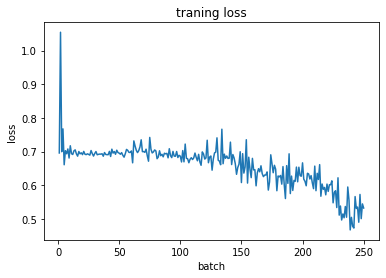

In [ ]:
# plot training losses
# print(train_losses)
import matplotlib.pyplot as plt

x_axis = [i+1 for i in range(250)]
y_axis = train_losses

plt.plot(x_axis, y_axis)
plt.title('traning loss')
plt.xlabel('batch')
plt.ylabel('loss')
plt.show()

[0.409127414226532, 0.4724872410297394, 0.5416237115859985, 0.5012471675872803, 0.4851801097393036, 0.38161206245422363, 0.45775270462036133, 0.44291236996650696, 0.44267702102661133, 0.5327309370040894, 0.6081580519676208, 0.4698628783226013, 0.5025217533111572, 0.5606552958488464, 0.5723315477371216, 0.5666053295135498]


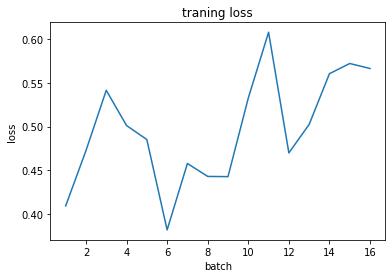

In [ ]:
# plot validation losses
print(valid_losses)
import matplotlib.pyplot as plt

x_axis = [i+1 for i in range(16)]
y_axis = valid_losses

plt.plot(x_axis, y_axis)
plt.title('traning loss')
plt.xlabel('batch')
plt.ylabel('loss')
plt.show()

In [ ]:
# evaluating the model with the testing dataset
!pip install torchmetrics
import torchmetrics
from torchmetrics.classification import BinaryConfusionMatrix

test_acc, test_loss, test_losses, preds = evaluate(model, loss_function, test_loader)
target = torch.as_tensor(y_test)

preds = torch.as_tensor(preds)
target = torch.squeeze(target)

bcm = BinaryConfusionMatrix()

print(test_acc)
print(bcm(preds, target))




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
tensor(0.6968, device='cuda:0')
tensor([[340, 207],
        [112, 393]])
